In [1]:
import os
import kagglehub

import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from typing import List, Tuple


/Users/vujasino/Documents/Research/Audits/git/merlin/.pixi/envs/default/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Downloading data

In [2]:
path = kagglehub.dataset_download("uciml/adult-census-income")
out_path = "../data/adult-census-income"
%rm -r $out_path
%mv $path $out_path

100%|██████████| 450k/450k [00:00<00:00, 940kB/s]

Extracting files...


## Data Loading and Analysis

Excerpt from a reference paper "We use age, years of education, capital gain, capital loss, hours-per-week, etc., as continuous features, and education level, gender, etc., as categorical features."

In [3]:
data_path = os.path.join(out_path, "adult.csv")
adult_df = pd.read_csv(data_path)
adult_df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [4]:
continuous_cols = ["age", "education.num", "capital.gain", "capital.loss", "hours.per.week"]
categorical_cols = ["education", "sex"]

### Data Analysis

#### NaN presence analysis

In [5]:
print("NaNs per continuous column:")
dict(zip(continuous_cols, adult_df[continuous_cols].isna().sum(axis=0)))

NaNs per continuous column:


{'age': 0,
 'education.num': 0,
 'capital.gain': 0,
 'capital.loss': 0,
 'hours.per.week': 0}

In [6]:
for col in categorical_cols:
    print(f"{col} values:", adult_df[col].unique())

education values: ['HS-grad' 'Some-college' '7th-8th' '10th' 'Doctorate' 'Prof-school'
 'Bachelors' 'Masters' '11th' 'Assoc-acdm' 'Assoc-voc' '1st-4th' '5th-6th'
 '12th' '9th' 'Preschool']
sex values: ['Female' 'Male']


#### Distributions

In [7]:
def get_approx_subplots_square(n: int) -> Tuple[int, int]:
    """
    Calculate the approximate number of rows and columns for subplots to form close to a square layout.

    Args:
        n (int): The total number of subplots.

    Returns:
        Tuple[int, int]: A tuple containing the number of rows and columns.
    """
    nrows = np.floor(np.sqrt(n)).astype(int)
    ncols = np.ceil(n / nrows).astype(int)
    return nrows, ncols

def square_subplots_prep(n: int, *args, **kwargs) -> Tuple[plt.Figure, np.ndarray]:
    """
    Prepare a square grid of subplots and return the figure and axes.

    This function creates a grid of subplots that is as close to square as possible,
    given the number of subplots `n`. It removes any unused subplots and flattens
    the axes array to return only the used subplots.

    Parameters:
    -----------
    n : int
        The number of subplots to create.
    *args : tuple
        Additional positional arguments to pass to `plt.subplots`.
    **kwargs : dict
        Additional keyword arguments to pass to `plt.subplots`.

    Returns:
    --------
    Tuple[plt.Figure, np.ndarray]
        A tuple containing the figure and an array of the used axes.
    """
    nrows, ncols = get_approx_subplots_square(n)
    fig, axs = plt.subplots(nrows, ncols, *args, **kwargs)
    # Remove unused subplots and flatten the axes array
    for ax in axs.reshape(-1)[n:]:
        fig.delaxes(ax)
    axs = axs.reshape(-1)[:n]
    return fig, axs

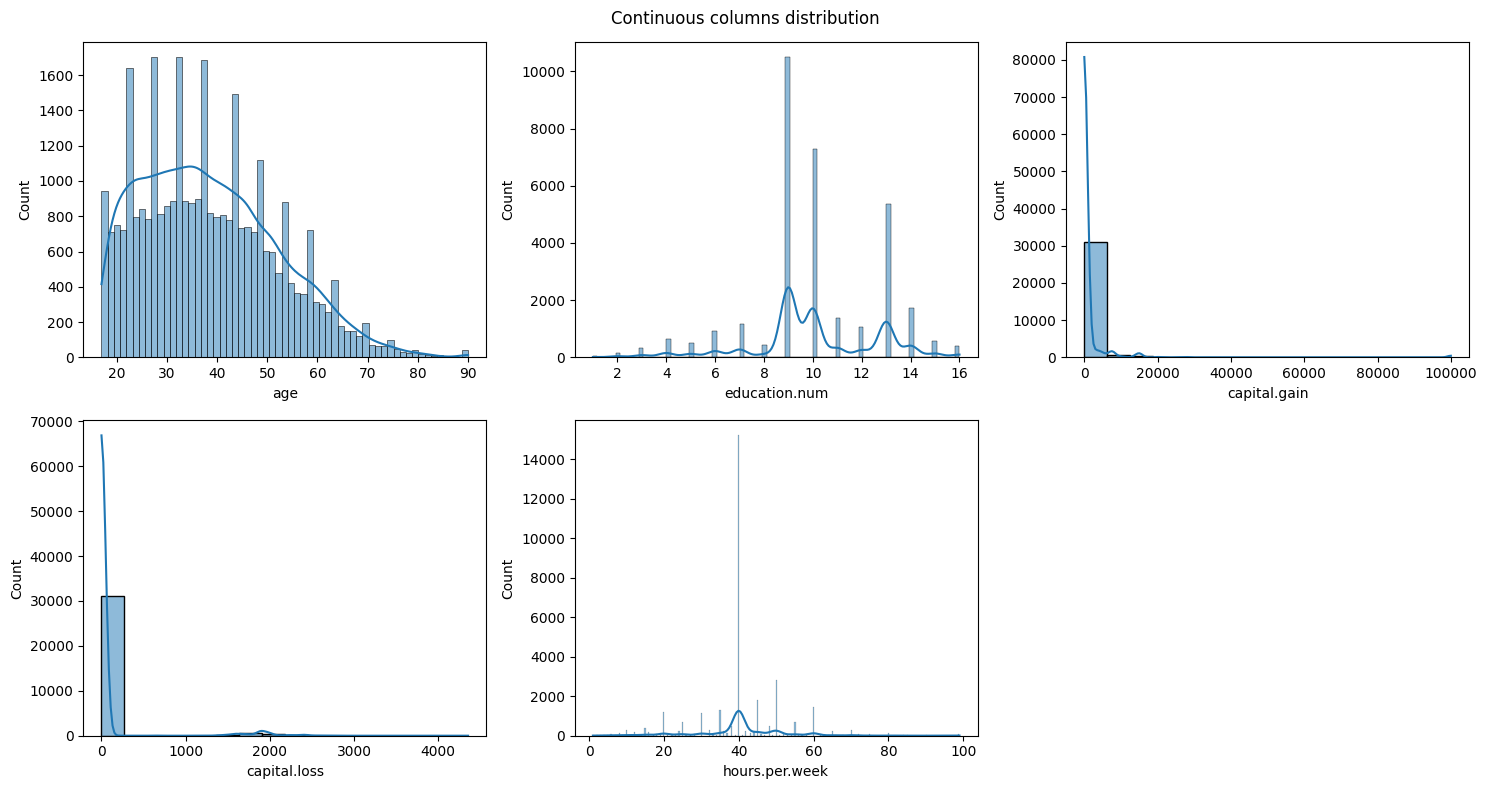

In [8]:
cols_to_plot = continuous_cols
fig, axs = square_subplots_prep(len(cols_to_plot), figsize=(15, 8))

for ax, col in zip(axs, cols_to_plot):
    sns.histplot(adult_df[col], kde=True, ax=ax)

fig.suptitle("Continuous columns distribution")
plt.tight_layout()
plt.show()

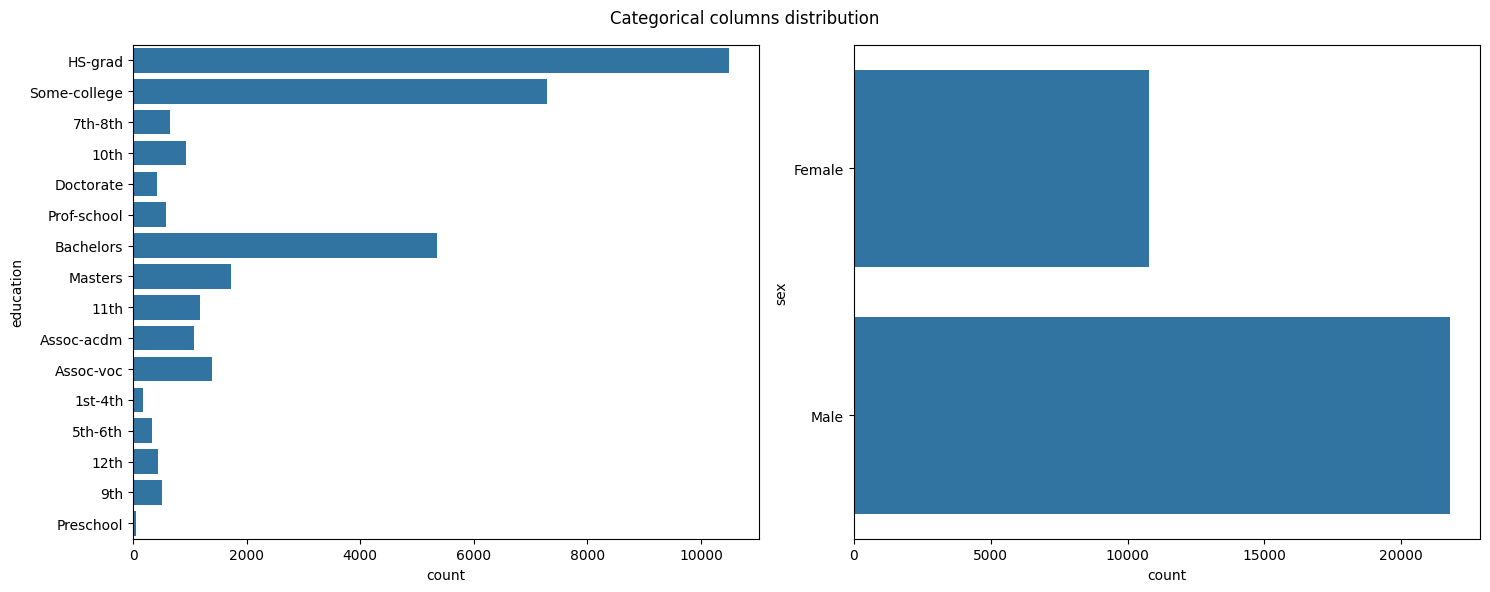

In [9]:
cols_to_plot = categorical_cols
fig, axs = square_subplots_prep(len(cols_to_plot), figsize=(15, 6))

for ax, col in zip(axs, cols_to_plot):
    sns.countplot(adult_df[col], ax=ax)

fig.suptitle("Categorical columns distribution")
plt.tight_layout()
plt.show()

### Processing Data

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
adult_df_X = adult_df[continuous_cols + categorical_cols]
adult_df_y = adult_df["income"]

In [12]:
fairly_normal_continuous_cols = ["age", "education.num", "hours.per.week"]

def create_pipeline(train_X_df: pd.DataFrame, train_y_series: pd.Series) -> dict:
    global continuous_cols, categorical_cols, fairly_normal_continuous_cols
    categorical_encoder = OneHotEncoder(drop="if_binary", sparse_output=False).fit(train_X_df[categorical_cols])
    y_encoder = OneHotEncoder(drop="if_binary", sparse_output=False).fit(train_y_series.to_frame())
    normal_dist_scaler = StandardScaler().fit(train_X_df[continuous_cols])
    return {
        "categorical_encoder": categorical_encoder,
        "y_encoder": y_encoder,
        "normal_dist_scaler": normal_dist_scaler
    }
    
def process_data(X_df: pd.DataFrame, y_series: pd.Series, pipeline: dict):
    global continuous_cols, categorical_cols, fairly_normal_continuous_cols
    X_df = X_df.copy()
    categorical_cols_encodings = pipeline["categorical_encoder"].transform(X_df[categorical_cols])
    X = np.concatenate([
        pipeline["normal_dist_scaler"].transform(X_df[continuous_cols]),
        categorical_cols_encodings
    ], axis=1)
    y = pipeline["y_encoder"].transform(y_series.to_frame()).reshape((-1,))
    sensitive_col = X_df["sex"] == "Female"
    return X, y, sensitive_col

adult_df_X_train_df, adult_df_X_test_df, adult_df_y_train_df, adult_df_y_test_df = train_test_split(
    adult_df_X, adult_df_y, test_size=0.2, random_state=42, stratify=adult_df_X["sex"])
pipeline = create_pipeline(adult_df_X_train_df, adult_df_y_train_df)
adult_X_train, adult_y_train, sensitive_col_train = process_data(adult_df_X_train_df, adult_df_y_train_df, pipeline)
adult_X_test, adult_y_test, sensitive_col_test = process_data(adult_df_X_test_df, adult_df_y_test_df, pipeline)
adult_X_train, adult_y_train, sensitive_col_train

(array([[-1.43207985, -0.03434848, -0.14725877, ...,  0.        ,
          1.        ,  0.        ],
        [-0.62747303, -0.42250869, -0.14725877, ...,  0.        ,
          0.        ,  1.        ],
        [-0.33488872, -0.42250869, -0.14725877, ...,  0.        ,
          0.        ,  1.        ],
        ...,
        [-0.55432695, -0.42250869, -0.14725877, ...,  0.        ,
          0.        ,  1.        ],
        [-1.06634948,  1.13013214, -0.14725877, ...,  0.        ,
          0.        ,  1.        ],
        [-1.13949555, -0.42250869, -0.14725877, ...,  0.        ,
          0.        ,  0.        ]]),
 array([0., 1., 0., ..., 0., 0., 0.]),
 30125     True
 27726    False
 17488    False
 18353    False
 2951     False
          ...  
 1647     False
 14550    False
 20233    False
 12612    False
 22520     True
 Name: sex, Length: 26048, dtype: bool)

In [13]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression(max_iter=1000).fit(adult_X_train, adult_y_train)

In [14]:
print("Accuracy:", logistic_regression.score(adult_X_test, adult_y_test))

Accuracy: 0.8203592814371258


In [15]:
senstive_test_X, sensitive_test_y = adult_X_test[sensitive_col_test], adult_y_test[sensitive_col_test]
non_senstive_test_X, non_sensitive_test_y = adult_X_test[~sensitive_col_test], adult_y_test[~sensitive_col_test]

In [16]:
from sklearn import clone
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError
from fairlearn.postprocessing import ThresholdOptimizer

class LogisticRegressionAsRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, logistic_regression_estimator):
        self.logistic_regression_estimator = logistic_regression_estimator

    def fit(self, X, y):
        try:
            check_is_fitted(self.logistic_regression_estimator)
            self.logistic_regression_estimator_ = self.logistic_regression_estimator
        except NotFittedError:
            self.logistic_regression_estimator_ = clone(
                self.logistic_regression_estimator
            ).fit(X, y)
        return self

    def predict(self, X):
        # use predict_proba to get real values instead of 0/1, select only prob for 1
        scores = self.logistic_regression_estimator_.predict_proba(X)[:, 1]
        return scores

estimator_wrapper = LogisticRegressionAsRegression(logistic_regression).fit(adult_X_train, adult_y_train)
postprocessed_predictor_EO = ThresholdOptimizer(
    estimator=estimator_wrapper, constraints="equalized_odds", prefit=True
)
postprocessed_predictor_EO.fit(adult_X_train, adult_y_train, sensitive_features=sensitive_col_train)

ThresholdOptimizer(constraints='equalized_odds',
                   estimator=LogisticRegressionAsRegression(logistic_regression_estimator=LogisticRegression(max_iter=1000)),
                   prefit=True)

In [17]:
print("BASE ESTIMATOR:")

print("Accuracy on sensitive data:", 
      estimator_wrapper.logistic_regression_estimator_.score(adult_X_test[sensitive_col_test], adult_y_test[sensitive_col_test]))
print("Accuracy on non-sensitive data:",
      estimator_wrapper.logistic_regression_estimator_.score(adult_X_test[~sensitive_col_test], adult_y_test[~sensitive_col_test]))

print("=" * 80)

y_col_to_show = 1
y_col_val = pipeline["y_encoder"].categories_[0][y_col_to_show]


print(f"P(income{y_col_val} | female) =",
      (estimator_wrapper.logistic_regression_estimator_.predict(adult_X_test[sensitive_col_test]) == y_col_to_show).mean())
print(f"P(income{y_col_val} | male) =",
      (estimator_wrapper.logistic_regression_estimator_.predict(adult_X_test[~sensitive_col_test]) == y_col_to_show).mean())

BASE ESTIMATOR:
Accuracy on sensitive data: 0.9080779944289693
Accuracy on non-sensitive data: 0.7770130763936682
P(income>50K | female) = 0.03714020427112349
P(income>50K | male) = 0.19385180087175957


In [18]:
fair_y_test_predictions = postprocessed_predictor_EO.predict(adult_X_test, sensitive_features=sensitive_col_test)

correct_prediction = (fair_y_test_predictions == adult_y_test)
print("Fair model accuracy:", correct_prediction.mean())

Fair model accuracy: 0.8050053738676494


In [19]:
print("Fair model accuracy on sensitive data:",
      correct_prediction[sensitive_col_test].mean())
print("Fair model accuracy on non-sensitive data:",
      correct_prediction[~sensitive_col_test].mean())

Fair model accuracy on sensitive data: 0.8857938718662952
Fair model accuracy on non-sensitive data: 0.76508373480156


In [20]:
fair_y_test_predictions[sensitive_col_test].mean(), fair_y_test_predictions[~sensitive_col_test].mean()

(np.float64(0.07613741875580315), np.float64(0.12869924294562973))

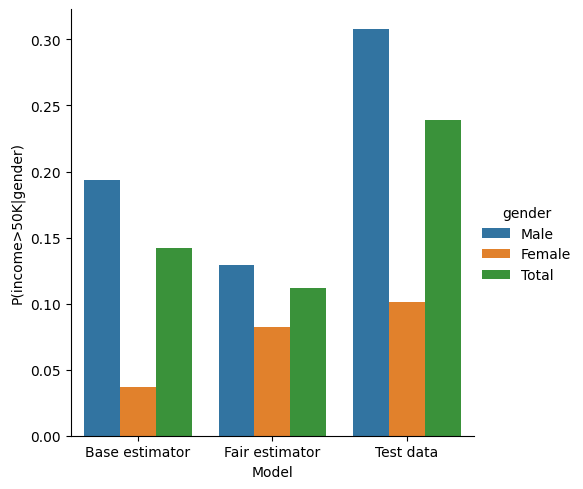

In [21]:
result_list = []

for i, y_col_val in enumerate(pipeline["y_encoder"].categories_[0]):
    for model_name, model in zip(["Base estimator", "Fair estimator", "Test data"], [estimator_wrapper.logistic_regression_estimator_, postprocessed_predictor_EO, None]):
        for gender_name, mask in zip(["Male", "Female", "Total"], [~sensitive_col_test, sensitive_col_test, np.ones_like(sensitive_col_test)]):
            y_col_name = f"income{y_col_val}"
            if model is None:
                predictions = adult_y_test
            elif isinstance(model, ThresholdOptimizer):
                predictions = model.predict(adult_X_test, sensitive_features=sensitive_col_test)
            else:
                predictions = model.predict(adult_X_test)
            result_list.append({
                "model": model_name,
                "target_col": y_col_name,
                "gender": gender_name,
                "mean_proba": (predictions[mask] == i).mean()
            })
    
result_df = pd.DataFrame(result_list)
# print(result_df)

val_to_show = "income>50K"
sns.catplot(data=result_df[result_df["target_col"] == val_to_show], x="model", y="mean_proba", hue="gender", kind="bar")
plt.xlabel("Model")
plt.ylabel(f"P({val_to_show}|gender)")
plt.show()

# CelebA

In [22]:
# path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
celeba_path = "../data/celeba-dataset"
# %rm -r $celeba_path
# %mv $path $celeba_path

In [23]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from glob import glob
from PIL import Image

In [24]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
image_pre_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

In [25]:
celeba_df = pd.read_csv(os.path.join(celeba_path, "list_attr_celeba.csv"))
print(celeba_df[["Black_Hair", "Brown_Hair", "Blond_Hair", "Gray_Hair"]])
print(list(filter(lambda x: "Hair" in x, celeba_df.columns)))
celeba_df.head()

        Black_Hair  Brown_Hair  Blond_Hair  Gray_Hair
0               -1           1          -1         -1
1               -1           1          -1         -1
2               -1          -1          -1         -1
3               -1          -1          -1         -1
4               -1          -1          -1         -1
...            ...         ...         ...        ...
202594          -1          -1           1         -1
202595          -1          -1           1         -1
202596           1          -1          -1         -1
202597           1          -1          -1         -1
202598          -1          -1           1         -1

[202599 rows x 4 columns]
['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair', 'Receding_Hairline', 'Straight_Hair', 'Wavy_Hair']


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [26]:
train_data_path_celeba = os.path.join(celeba_path, "train_data")
# %mkdir -p $train_data_path_celeba
# %mkdir -p $train_data_path_celeba/brown
# %mkdir -p $train_data_path_celeba/nonbrown

In [ ]:
from torchvision.datasets.folder import default_loader
from torch.utils.data import Dataset


from typing import Optional, Callable, Any

class CelebAImageDataset(Dataset):
    """
    A custom Dataset class for loading images and their attributes from the CelebA dataset.
    Args:
        attr_df (pd.DataFrame): DataFrame containing image attributes and metadata.
        image_folder_path (str): Path to the folder containing the images.
        target_column (str): The column name in attr_df that contains the target labels.
        additional_attributes_to_provide (Optional[List[str] | str], optional): Additional attributes to provide along with the image and target. Defaults to None.
        transform (Optional[Callable], optional): A function/transform to apply to the images. Defaults to None.
        target_transform (Optional[Callable], optional): A function/transform to apply to the target labels. Defaults to None.
        additional_attributes_transform (Optional[Callable], optional): A function/transform to apply to the additional attributes. Defaults to None.
        loader (Callable[[str], Any], optional): A function to load an image given its path. Defaults to default_loader.
        enable_caching (bool, optional): Whether to cache the loaded samples. Defaults to False.
    Raises:
        ValueError: If the target column or additional attributes are not found in the DataFrame.
    Methods:
        __len__(): Returns the number of samples in the dataset.
        __getitem__(idx: int): Returns a tuple containing the image, target, and optionally additional attributes for the given index.
    """
    def __init__(self, 
                 attr_df, 
                 image_folder_path,
                 target_column, 
                 additional_attributes_to_provide: Optional[List[str] | str] = None,
                 transform: Optional[Callable] = None,
                 target_transform: Optional[Callable] = None,
                 additional_attributes_transform: Optional[Callable] = None,
                 loader: Callable[[str], Any] = default_loader,
                 enable_caching: bool = False):
        if target_column not in attr_df.columns:
            raise ValueError(f"Target column '{target_column}' not found in the DataFrame.")
        if additional_attributes_to_provide is not None:
            to_check_attributes = additional_attributes_to_provide
            if isinstance(additional_attributes_to_provide, str):
                to_check_attributes = [additional_attributes_to_provide]
            for attr in to_check_attributes:
                if attr not in attr_df.columns:
                    raise ValueError(f"Attribute '{attr}' not found in the DataFrame.")
        self.attr_df = attr_df
        self.image_folder_path = image_folder_path
        self.target_column = target_column
        self.additional_attributes_to_provide = additional_attributes_to_provide
        self.transform = transform
        self.target_transform = target_transform
        self.additional_attributes_transform = additional_attributes_transform
        self.loader = loader
        self.enable_caching = enable_caching
        self.__cache = {}
        
    def __len__(self) -> int:
        return len(self.attr_df)
    
    def __getitem__(self, idx: int):
        # Cache Lookup if enabled
        if self.enable_caching and idx in self.__cache:
            return self.__cache[idx]
        # Sample Loading
        entry = self.attr_df.iloc[idx]
        img_path = os.path.join(self.image_folder_path, entry["image_id"])
        img = self.loader(img_path)
        if self.transform is not None:
            img = self.transform(img)
        target = entry[self.target_column]
        if self.target_transform is not None:
            target = self.target_transform(target)
        # Preparing the result tuple
        if self.additional_attributes_to_provide is not None:
            additional_attributes = entry[self.additional_attributes_to_provide]
            if self.additional_attributes_transform is not None:
                additional_attributes = self.additional_attributes_transform(additional_attributes)
            if isinstance(additional_attributes, pd.Series):
                additional_attributes = additional_attributes.to_dict()
            result = (img, target, additional_attributes)
        else:
            result = (img, target)
        # Caching the result if enabled
        if self.enable_caching:
            self.__cache[idx] = result
        return result
    
dataset = CelebAImageDataset(celeba_df, 
                            os.path.join(celeba_path, "img_align_celeba", "img_align_celeba"), 
                            "Blond_Hair",
                            additional_attributes_to_provide=["Male"],
                            transform=image_pre_transform,
                            target_transform=lambda x: int(x == 1),
                            enable_caching=False)

dl = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

for x in dl:
    print(x)
    break

[tensor([[[[ 2.0605,  2.0605,  2.0605,  ...,  1.7865,  1.7865,  1.7865],
          [ 2.0605,  2.0605,  2.0605,  ...,  1.7865,  1.7865,  1.7865],
          [ 2.0605,  2.0605,  2.0605,  ...,  1.7865,  1.7865,  1.7865],
          ...,
          [-0.3027, -0.3541, -0.4054,  ...,  0.4337,  0.4337,  0.4337],
          [-0.3541, -0.4054, -0.4739,  ...,  0.4337,  0.4337,  0.4337],
          [-0.4397, -0.4911, -0.5596,  ...,  0.4508,  0.4508,  0.4508]],

         [[ 2.3060,  2.3060,  2.3060,  ...,  2.0784,  2.0784,  2.0784],
          [ 2.3060,  2.3060,  2.3060,  ...,  2.0784,  2.0784,  2.0784],
          [ 2.3060,  2.3060,  2.3060,  ...,  2.0784,  2.0784,  2.0784],
          ...,
          [-0.7227, -0.7752, -0.8277,  ...,  0.8529,  0.8529,  0.8529],
          [-0.7752, -0.8277, -0.8627,  ...,  0.8529,  0.8529,  0.8529],
          [-0.8452, -0.8803, -0.9153,  ...,  0.8354,  0.8354,  0.8354]],

         [[ 2.5354,  2.5354,  2.5354,  ...,  2.3960,  2.3960,  2.3960],
          [ 2.5354,  2.5354, 

In [220]:
from tqdm import tqdm

for p in resnet18.parameters():
    p.requires_grad = False

resnet18.fc = torch.nn.Linear(resnet18.fc.in_features, 2)
resnet18 = resnet18.to("mps")
optimizer = torch.optim.SGD(resnet18.parameters(), lr=0.1, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

def acc(model, loader):
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            pred = model(x.to("mps")).argmax(dim=1)
            correct += (pred == y.to("mps")).sum().item()
            total += y.size(0)
    return correct / total

print("Accuracy:", acc(resnet18, train_loader))

for _ in range(10):
    for x, y in tqdm(train_loader):
        x = x.to("mps")
        y = y.to("mps")
        optimizer.zero_grad()
        out = resnet18(x)
        loss = criterion(out, y)
        loss.backward()
        
        optimizer.step()
        

    print("Accuracy:", acc(resnet18, train_loader))

Accuracy: 0.4425


100%|██████████| 8/8 [00:00<00:00,  9.37it/s]


Accuracy: 0.6025


100%|██████████| 8/8 [00:00<00:00,  9.37it/s]


Accuracy: 0.785


100%|██████████| 8/8 [00:00<00:00,  9.28it/s]


Accuracy: 0.6125


100%|██████████| 8/8 [00:00<00:00,  9.27it/s]


Accuracy: 0.82


100%|██████████| 8/8 [00:00<00:00,  9.35it/s]


Accuracy: 0.81


100%|██████████| 8/8 [00:00<00:00,  9.32it/s]


Accuracy: 0.73


100%|██████████| 8/8 [00:00<00:00,  9.32it/s]


Accuracy: 0.8575


100%|██████████| 8/8 [00:00<00:00,  8.82it/s]


Accuracy: 0.905


100%|██████████| 8/8 [00:00<00:00,  9.23it/s]


Accuracy: 0.8525


100%|██████████| 8/8 [00:00<00:00,  9.29it/s]


Accuracy: 0.9025


In [159]:
print("Brown hair people: ", (celeba_df["Brown_Hair"] == 1).sum().item())
print("Blond hair people: ", (celeba_df["Blond_Hair"] == 1).sum().item())
print("Black hair people: ", (celeba_df["Black_Hair"] == 1).sum().item())


print("Black and Blond hair people: ", ((celeba_df["Black_Hair"] == 1) & (celeba_df["Blond_Hair"] == 1)).sum().item())
print("Brown and Blond hair people: ", ((celeba_df["Brown_Hair"] == 1) & (celeba_df["Blond_Hair"] == 1)).sum().item())
print("Brown and Black hair people: ", ((celeba_df["Brown_Hair"] == 1) & (celeba_df["Black_Hair"] == 1)).sum().item())

Brown hair people:  41572
Blond hair people:  29983
Black hair people:  48472
Black and Blond hair people:  3
Brown and Blond hair people:  1220
Brown and Black hair people:  1136


In [229]:
celeba_df.columns

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')

In [228]:
((celeba_df["Male"] == 1) & (celeba_df["Black_Hair"] == 1)).sum() / (celeba_df["Male"] == 1).sum()

np.float64(0.2979368500840893)

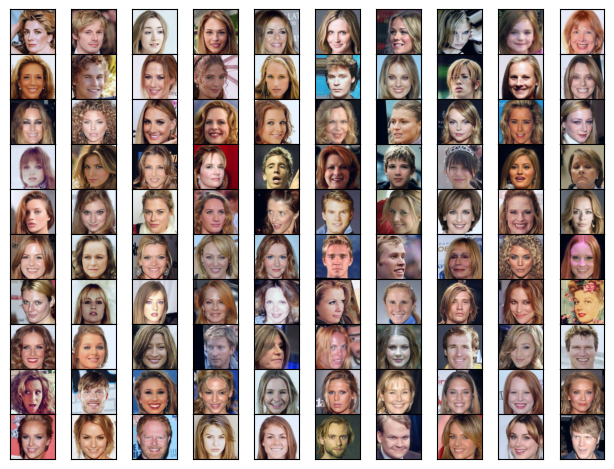

In [ ]:
dual_hair_entries = celeba_df[(celeba_df["Brown_Hair"] == 1) & (celeba_df["Blond_Hair"] == 1)] 

def normalize_to_unit(x):
    return (x - x.min()) / (x.max() - x.min())

grid_size = 10
fig, axs = plt.subplots(grid_size, grid_size, sharex=True, sharey=True)
axs = axs.flatten()
for im_name, ax in zip(dual_hair_entries["image_id"].sample(min(len(axs), len(dual_hair_entries["image_id"]))), axs):
    img = image_pre_transform(Image.open(os.path.join(celeba_image_folder, im_name)))
    if img.shape[0] == 3:
        img = normalize_to_unit(img.permute(1, 2, 0))
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.show()

In [95]:
resnet18 = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)